In [1]:
import numpy as np

subjectList = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 
               '11', '12', '13', '14', '15']
data = []
labels = []

# Load data for each subject and append to data and labels lists
for subjects in subjectList:
    with open(f'./pre_data/s{subjects}.npy', 'rb') as file:
        sub = np.load(file, allow_pickle=True)
        for trial in sub:
            # Append the entire dataset to data and labels
            data.append(trial[0])   # EEG data
            labels.append(trial[1]) # Corresponding labels

# Save the complete data and labels as .npy files
np.save('./Mini_Data/complete_data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('./Mini_Data/complete_labels', np.array(labels), allow_pickle=True, fix_imports=True)

# Print out the shapes of the saved data and labels to confirm
print("Complete dataset:", np.array(data).shape, np.array(labels).shape)


Complete dataset: (292800, 128) (292800, 4)


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the complete data and labels
data = np.load('./Mini_Data/complete_data.npy', allow_pickle=True)
labels = np.load('./Mini_Data/complete_labels.npy', allow_pickle=True)

# Split the data into an 80% training and 20% testing set
data_training, data_testing, label_training, label_testing = train_test_split(
    data, labels, test_size=0.20, random_state=42
)

# Save the training and testing sets as .npy files
np.save('./Data/data_training.npy', data_training, allow_pickle=True, fix_imports=True)
np.save('./Data/label_training.npy', label_training, allow_pickle=True, fix_imports=True)
np.save('./Data/data_testing.npy', data_testing, allow_pickle=True, fix_imports=True)
np.save('./Data/label_testing.npy', label_testing, allow_pickle=True, fix_imports=True)

# Print out the shapes of the training and testing datasets
print("Training dataset:", data_training.shape, label_training.shape)
print("Testing dataset:", data_testing.shape, label_testing.shape)


Training dataset: (234240, 128) (234240, 4)
Testing dataset: (58560, 128) (58560, 4)


## Converting into Training data.

In [3]:
from sklearn import svm
import numpy as np
from sklearn.preprocessing import normalize
from keras.utils import to_categorical


with open('./Data/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open('./Data/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

x_train = np.array(X[:])
y_train = to_categorical(Arousal_Train)

## Converting into Test data. 

In [4]:
with open('./Data/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('./Data/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])

x_test = np.array(M[:])
     
y_test = to_categorical(Arousal_Test)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [6]:
import torch

# Determine if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU device 0")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Convert NumPy arrays to PyTorch tensors and shift them to the specified device
x_train = torch.Tensor(x_train).to(device)
y_train = torch.Tensor(y_train).to(device)
x_test = torch.Tensor(x_test).to(device)
y_test = torch.Tensor(y_test).to(device)


Using GPU device 0


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_shape[0], out_channels=64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=1, stride=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=1, stride=1)
        # Adjust the input features to the linear layer according to your network's architecture
        self.fc1 = nn.Linear(256, 256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.4)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

# Example usage
input_shape = (128, 1)  # As per your data shape
num_classes = 10  # Adjust as per your number of classes
model = CustomCNN(input_shape, num_classes)
model = model.to(device)

print(model)

CustomCNN(
  (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Lin

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from tqdm import tqdm

# Assuming model, x_train, y_train, x_test, y_test are already defined

# Define your PyTorch model (e.g., model = CustomCNN(input_shape, num_classes))
# model = CustomCNN(input_shape, num_classes)

# Move model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert tensors to datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_test, y_test)

# Convert datasets to DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Initialize lists for storing metrics
train_losses, train_accuracies, train_f1_scores = [], [], []
val_losses, val_accuracies, val_f1_scores = [], [], []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss, train_correct, train_total = 0.0, 0, 0
    all_train_labels, all_train_predictions = [], []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]", unit="batch")
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, labels_indices = torch.max(labels, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels_indices).sum().item()

        all_train_labels.extend(labels_indices.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

        train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader_tqdm), accuracy=100.0 * train_correct / train_total)

    train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100.0 * train_correct / train_total)
    train_f1_scores.append(train_f1)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_val_labels, all_val_predictions = [], []

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]", unit="batch")
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            _, labels_indices = torch.max(labels, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels_indices).sum().item()

            all_val_labels.extend(labels_indices.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

            val_loader_tqdm.set_postfix(loss=val_loss/len(val_loader_tqdm), accuracy=100.0 * val_correct / val_total)

    val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100.0 * val_correct / val_total)
    val_f1_scores.append(val_f1)

# After training, you can plot the stored metrics using your preferred plotting library (e.g., matplotlib)


Epoch 200/200 [Validation]: 100%|██████████| 229/229 [00:00<00:00, 239.78batch/s, accuracy=85.1, loss=0.436]


In [9]:
final_training_accuracy = train_accuracies[-1]
final_validation_accuracy = val_accuracies[-1]
average_training_accuracy = sum(train_accuracies) / len(train_accuracies)
average_validation_accuracy = sum(val_accuracies) / len(val_accuracies)

# Printing or logging the accuracies
print(f"Final Training Accuracy: {final_training_accuracy}%")
print(f"Final Validation Accuracy: {final_validation_accuracy}%")
print(f"Average Training Accuracy: {average_training_accuracy}%")
print(f"Average Validation Accuracy: {average_validation_accuracy}%")

Final Training Accuracy: 83.2808230874317%
Final Validation Accuracy: 85.14002732240438%
Average Training Accuracy: 77.48469304986342%
Average Validation Accuracy: 79.8856471994536%


In [10]:
final_train_f1 = train_f1_scores[-1]
final_val_f1 = val_f1_scores[-1]
average_train_f1 = np.mean(train_f1_scores)
average_val_f1 = np.mean(val_f1_scores)

# Printing or logging the F1 scores
print(f"Final Training F1 Score: {final_train_f1}")
print(f"Final Validation F1 Score: {final_val_f1}")
print(f"Average Training F1 Score: {average_train_f1}")
print(f"Average Validation F1 Score: {average_val_f1}")

Final Training F1 Score: 0.8331438720195921
Final Validation F1 Score: 0.8516105295456594
Average Training F1 Score: 0.7751547560654969
Average Validation F1 Score: 0.7991932100371639


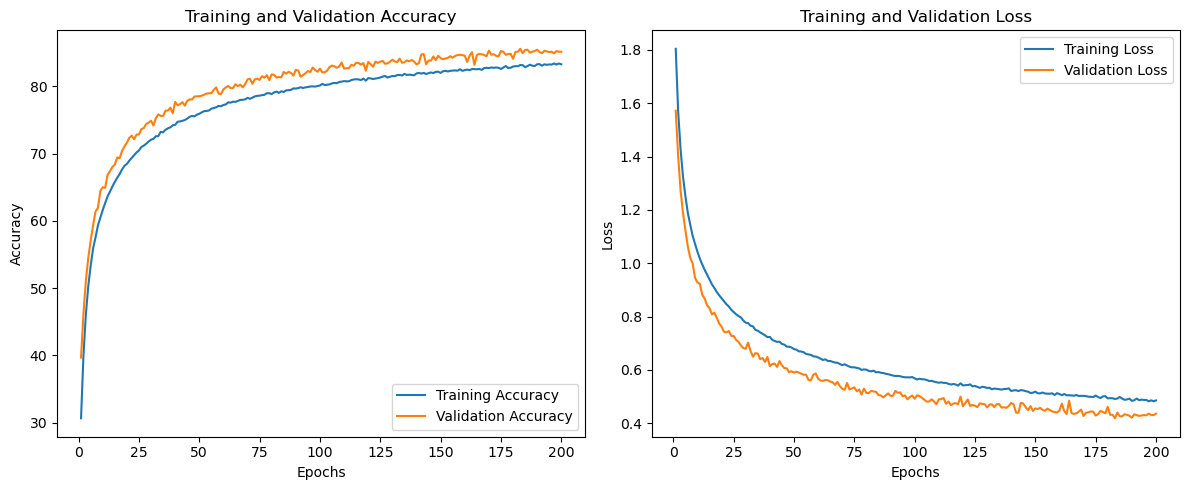

In [11]:
import matplotlib.pyplot as plt



epochs = range(1, len(train_accuracies) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
torch.save(model, r"C:/Users/gajapaka/Desktop/pre_data/model_arousalmini.pt")

In [13]:
# Model class must be defined somewhere
model = torch.load("C:/Users/gajapaka/Desktop/pre_data/model_arousalmini.pt")
model.eval()

CustomCNN(
  (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Lin

In [22]:
# Assuming 'model' is your trained model and 'device' is your computation device (cpu or cuda)
model.eval()  # Set the model to evaluation mode

# Select a single sample from x_test
single_input = x_test[11]  # Replace 0 with the index of the sample you want to test

# Reshape the sample to add a batch dimension
single_input = single_input.unsqueeze(0)

# Move the sample to the same device as the model
single_input = single_input.to(device)

# Make a prediction
with torch.no_grad():
    output = model(single_input)

# Convert output to a predicted class
_, predicted_class = torch.max(output, 1)

# Print the predicted class
print("Predicted class:", predicted_class.item())

# Optional: Compare with actual label if available
# Assuming y_test contains the labels and is a tensor
actual_label = y_test[11]# Replace 0 with the same index as above if comparing
torch.max(output, 1)
print("Actual class:", actual_label)

Predicted class: 7
Actual class: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')


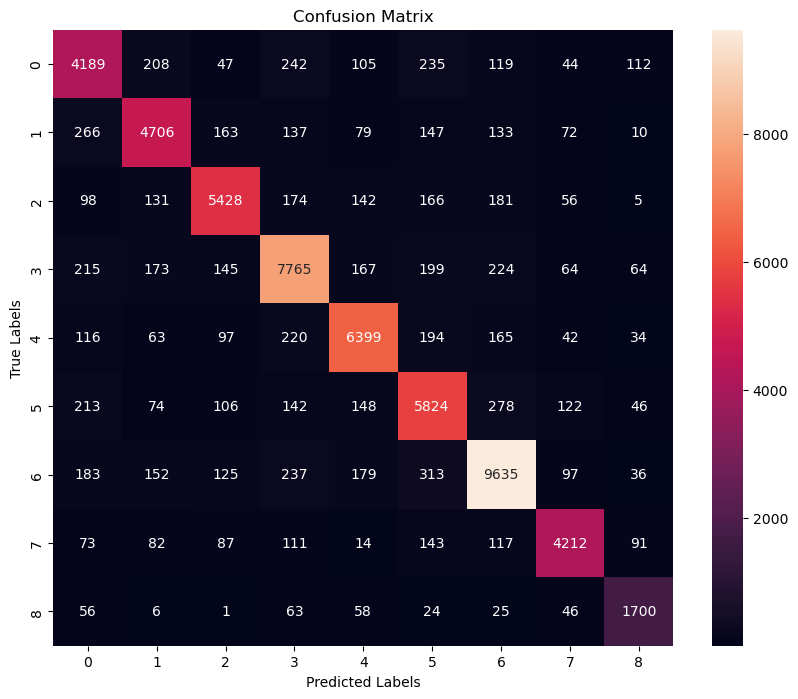

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()  # Set the model to evaluation mode
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Convert predictions from one-hot encoded to class indices
        predicted = np.argmax(outputs.cpu().numpy(), axis=1)
        all_preds.extend(predicted)

        # Convert true labels from one-hot encoded to class indices
        true_labels = np.argmax(labels.cpu().numpy(), axis=1)
        all_true.extend(true_labels)

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()